In [338]:
import numpy as np
import matplotlib.pyplot as plt
import wikipediaapi
import scipy.sparse as sps
import seaborn
import csv

valeur exacte [0.32421561 0.24671494 0.42906946]
valeur approchée [0.38778971 0.21481063 0.39739966]


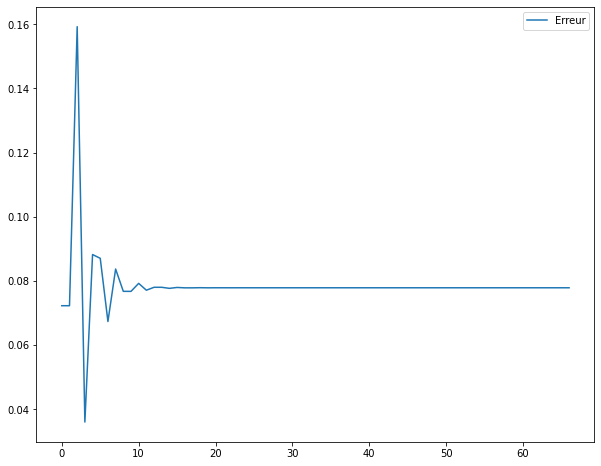

In [339]:
# Power iteration avec la somme
def power_iteration(dict1,tab,alpha): # fonction qui va calculer la valeur d'une page rank une par une
    nb_sommet=len(dict1)
    page_rank_final=np.zeros(nb_sommet) # tableau avec les nouvelles valeurs de page rank
    constante=(1-alpha)/nb_sommet

    for cles in dict1: # parcours de tous les sommets de notre graphe
        #print("cles",cles)
        somme=0
        for cles2 in dict1: # on parcours tous les sommets de notre graphe
            if cles in dict1[cles2]: # si un sommet de notre premier parcours se trouve dans l'ensemble on va l'ajouter avec la formule
                #print("sommet",cles2)
                somme=somme+(tab[cles2]/len(dict1[cles2]))  
                #print("valeur du page rank",tab[cles2-1])
                #print("nombre d'arcs sortants",len(dict1[cles2]))
        page_rank_final[cles]=alpha*somme+constante
    return page_rank_final


#Test:
dict2={0:{1,2}, 1:{2}, 2:{0}}
tab=np.ones(len(dict2))/len(dict2)
alpha=0.85
epsilon=0.00000000000001
#print(len(dict2))

#Valeur exacte
constante_exacte=(1-alpha/len(dict2))
page_rank_exacte=np.ones(len(dict2))
e=np.ones(len(dict2))
P=np.array([[1/3,1/3,1/3],[0,1/2,1/2],[1/2,0,1/2]])
A=np.transpose((np.identity(3)-alpha*P))
B=((1-alpha)/len(dict2))*np.transpose(e)
pi=np.linalg.solve(A,B)
print("valeur exacte",pi)

#Erreur
page_rank_1=power_iteration(dict2,tab,alpha)
iteration=1
E=[]
E.append(np.linalg.norm(pi-page_rank_1))

epsilon=0.000000000000001
while(np.linalg.norm(page_rank_1-tab)>epsilon):    
    E.append(np.linalg.norm(pi-page_rank_1))
    iteration=iteration+1
    tab=page_rank_1
    page_rank_1=power_iteration(dict2,tab,alpha)

print("valeur approchée",page_rank_1)
#print(iteration)
#print(dict2)
erreur=np.array(E)
nb_iteration=np.arange(0,iteration,1)

plt.figure(figsize=[10,8])
plt.plot(nb_iteration,erreur,label="Erreur")
plt.legend()
plt.show()

In [340]:
"""def power_iteration_erreur(dict1,tab,alpha,epsilon): # fonction qui va calculer la valeur d'une page rank une par une
    nb_sommet=len(dict1)
    page_rank=np.zeros(nb_sommet) # tableau avec les nouvelles valeurs de page rank
    constante=(1-alpha)/nb_sommet
    page_rank_temp=np.zeros(nb_sommet)
    iteration=0
    while(np.linalg.norm(tab-page_rank_temp)>epsilon): 
        iteration=iteration+1
        print(iteration)
        print("tab avant affectation",tab)
        print("page_rank_temp avant affectation",page_rank_temp)
        page_rank_temp=tab
        print("page_rank_temp apres affectation",page_rank_temp)
        for cles in dict1: # parcours de tous les sommets de notre graphe
            somme=0
            for cles2 in dict1: # on parcours tous les sommets de notre graphe
                if cles in dict1[cles2]: # si un sommet de notre premier parcours se trouve dans l'ensemble on va l'ajouter avec la formule
                    somme=somme+(tab[cles2]/len(dict1[cles2]))
            page_rank[cles]=alpha*somme+constante
        tab=page_rank
        print("nouvelle page_rank",page_rank)
        print("tab apres affectation",tab)
        print("page_rank_temp",page_rank_temp)
    return tab,iteration

#Test:
dict2={0:{1,2}, 1:{2}, 2:{0}}
tab=np.ones(len(dict2))/len(dict2)
alpha=0.85
epsilon=0.00000000000001

print(power_iteration_erreur(dict2,tab,alpha,epsilon))"""

'def power_iteration_erreur(dict1,tab,alpha,epsilon): # fonction qui va calculer la valeur d\'une page rank une par une\n    nb_sommet=len(dict1)\n    page_rank=np.zeros(nb_sommet) # tableau avec les nouvelles valeurs de page rank\n    constante=(1-alpha)/nb_sommet\n    page_rank_temp=np.zeros(nb_sommet)\n    iteration=0\n    while(np.linalg.norm(tab-page_rank_temp)>epsilon): \n        iteration=iteration+1\n        print(iteration)\n        print("tab avant affectation",tab)\n        print("page_rank_temp avant affectation",page_rank_temp)\n        page_rank_temp=tab\n        print("page_rank_temp apres affectation",page_rank_temp)\n        for cles in dict1: # parcours de tous les sommets de notre graphe\n            somme=0\n            for cles2 in dict1: # on parcours tous les sommets de notre graphe\n                if cles in dict1[cles2]: # si un sommet de notre premier parcours se trouve dans l\'ensemble on va l\'ajouter avec la formule\n                    somme=somme+(tab[cl

In [341]:
#Power iteration avec matrice
def creation_p(dict2): # conversion de notre dictionnaire à la matrice de transition
    nb_sommet=len(dict2)
    P=np.zeros((nb_sommet,nb_sommet))
    for cle in dict2:
        for sommet in dict2[cle]:
            P[cle,sommet]=1/len(dict2[cle])
    return P

def power_iteration_matrice(dict2,pi,alpha): # calcul de la valeur du page rank de manière matricielle
    nb_sommet=len(dict2)
    P=creation_p(dict2)
    constante=((1-alpha)/nb_sommet)*np.ones(nb_sommet)
    return alpha*np.dot(pi,P)+constante

#Test:
dict2={0:{1,2}, 1:{2}, 2:{0}}
tab=np.ones(len(dict2))/len(dict2)
pi_0=np.ones((1,len(dict2)))/len(dict2)
alpha=0.85

#Erreur
page_rank_2=power_iteration_matrice(dict2,pi_0,alpha)
iteration2=1

epsilon=0.00000000000001
while(np.linalg.norm(page_rank_2-pi_0)>epsilon): 
    iteration2=iteration2+1
    pi_0=page_rank_2
    page_rank_2=power_iteration_matrice(dict2,pi_0,alpha)

print(page_rank_2)
print(iteration2)


[[0.38778971 0.21481063 0.39739966]]
62


In [344]:
def power_iteration_matrice_erreur(dict2,alpha,epsilon): # calcul de la valeur du page rank de manière matricielle avec erreur epsilon
    nb_sommet=len(dict2)
    P=creation_p(dict2)
    e=np.array([(1-alpha)/nb_sommet]*nb_sommet)
    pi_avant=np.array(e)
    pi=[0]*nb_sommet
    while(np.linalg.norm(pi-pi_avant)>epsilon):
        pi_avant=pi
        pi=alpha*np.dot(pi_avant,P)+e
    return pi

#Test:
dict2={0:{0,1,2}, 1:{1,2}, 2:{0,2}}
print(power_iteration_matrice_erreur(dict2,pi_0,alpha,epsilon))

[0.32421561 0.24671494 0.42906946]


In [345]:
#Power iteration avec sparse
def dict_sparse(dict2):
    data=[]
    row_ind=[]
    col_ind=[]
    for cle in dict2:
        for sommet in dict2[cle]:
            data.append(1/len(dict2[cle]))
            row_ind.append(cle)
            col_ind.append(sommet)
    return scipy.sparse.csr_matrix((data,(row_ind,col_ind)),shape=(len(dict2),len(dict2)))

def dict_sparse2(dict2):
    data=[]
    row_ind=[]
    col_ind=[]
    for cle in dict2:
        for sommet in dict2[cle]:
            row_ind.append(cle)
            col_ind.append(sommet)
    return row_ind,col_ind

P_sparse=dict_sparse(dict2)
print(type(P_sparse))
print(P_sparse)

def power_iteration_sparse(dict2,pi,alpha):
    nb_sommet=len(dict2)
    P=dict_sparse(dict2)
    constante=((1-alpha)/nb_sommet)*np.ones(nb_sommet)
    P_t=P.transpose()
    pi_t=pi.transpose()
    return (alpha*P_t.dot(pi_t)).transpose()+constante

def power_iteration_sparse2(row,col,pi,alpha,n):
    valeurs=[1]*len(row)
    P=scipy.sparse.csr_matrix((valeurs,(row,col)))
    constante=((1-alpha)/n)*np.ones(n)
    P_t=P.transpose()
    pi_t=pi.transpose()
    return (alpha*P_t.dot(pi_t)).transpose()+constante


#Test:
dict2={0:{1,2}, 1:{2}, 2:{0}}
pi_0=np.ones((1,len(dict2)))/len(dict2)
alpha=0.85
row_ind,col_ind=dict_sparse2(dict2)

#Erreur
page_rank_2=power_iteration_sparse2(row_ind,col_ind,pi_0,alpha,3)
iteration2=1

epsilon=0.00000000000001
while(np.linalg.norm(page_rank_2-pi_0)>epsilon): 
    iteration2=iteration2+1
    pi_0=page_rank_2
    page_rank_2=power_iteration_sparse2(row_ind,col_ind,pi_0,alpha,3)

print(page_rank_2)
print(iteration2)

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 0)	0.3333333333333333
  (0, 1)	0.3333333333333333
  (0, 2)	0.3333333333333333
  (1, 1)	0.5
  (1, 2)	0.5
  (2, 0)	0.5
  (2, 2)	0.5
[[            inf 9.92659702e+307             inf]]
5981


/var/folders/5q/thc123cx2kz4n0kl6ls0hjmw0000gn/T/ipykernel_26781/925011685.py:55: RuntimeWarning: invalid value encountered in subtract
  while(np.linalg.norm(page_rank_2-pi_0)>epsilon):


In [353]:
def reader_lists(fileName):
	with open(fileName, 'r') as csvfile:
		rows = []
		cols = []
		edgelist = csv.reader(csvfile, delimiter=' ')
		for line in edgelist:
			rows.append( int(line[0]) )
			cols.append( int(line[1]) )

		return rows, cols
	
def pagerank_sparse(rows, cols, alpha, epsilon):	
	size = max(max(rows), max(cols)) + 1
	A = sps.csr_matrix(([1]*len(rows), (rows, cols)), shape=(size,size))
	A = A + sps.eye(size)
	D = A.dot([1]*size)
	Dinv = sps.diags([np.reciprocal(D)], [0])
	P = Dinv.dot(A)

	e=np.array([(1-alpha)/size]*size)
	pi_avant=np.array(e)
	pi=[0]*size
	Pt=P.transpose()

	while(np.linalg.norm(pi-pi_avant)>epsilon):
		pi_avant=pi
		pi=alpha*(Pt.dot(pi_avant))+e
	return pi

dict2={0:{1,2}, 1:{2}, 2:{0}}
rows,cols=dict_sparse2(dict2)
pi_0=np.ones((1,max(max(rows), max(cols)) + 1))/(max(max(rows), max(cols)) + 1)
page_rank=pagerank_sparse(rows,cols,0.85,0.00000001)
print(page_rank)

#Valeur exacte
constante_exacte=(1-alpha/len(dict2))
page_rank_exacte=np.ones(len(dict2))
e=np.ones(len(dict2))
P=np.array([[1/3,1/3,1/3],[0,1/2,1/2],[1/2,0,1/2]])
A=np.transpose((np.identity(3)-alpha*P))
B=((1-alpha)/len(dict2))*np.transpose(e)
pi=np.linalg.solve(A,B)


[0.32421558 0.24671492 0.42906942]


In [164]:
def power_iteration_sparse_erreur(dict2,pi,alpha,epsilon):
    nb_sommet=len(dict2)
    P=dict_sparse(dict2)
    constante=((1-alpha)/nb_sommet)*np.ones(nb_sommet)
    P_t=P.transpose()
    page_rank=np.zeros((1,len(dict2)))
    iteration=0
    while(np.linalg.norm(page_rank-pi)>epsilon):
        iteration=iteration+1
        page_rank=pi
        pi=(alpha*P_t.dot(page_rank.transpose())).transpose()+constante
    return pi,iteration

#Test:
dict2={0:{1,2}, 1:{2}, 2:{0}}
tab=np.ones(len(dict2))/len(dict2)
pi_0=np.ones((1,len(dict2)))/len(dict2)
alpha=0.85
epsilon=0.00000000000001

print(power_iteration_sparse_erreur(dict2,pi_0,alpha,epsilon))

(array([[0.38778971, 0.21481063, 0.39739966]]), 62)


In [267]:
#Power iteration Page Rank Personalisé avec matrice sparse

"""def power_iteration_sparse_perso(dict2,pi,alpha,tab):
    nb_sommet=len(dict2)
    P=dict_sparse(dict2)
    y=np.zeros(nb_sommet)
    compteur=0
    for i in tab:
        if(len(dict2[i])!=0 and compteur==0):
            compteur=1
        y[i-1]=1
    if(compteur==0):
        print("Mauvais choix de site")
        return 0
    constante=((1-alpha)/np.sum(y))*y
    P_t=P.transpose()
    pi_t=pi.transpose()
    return (alpha*P_t.dot(pi_t)).transpose()+constante
"""
#Test:
dict2={0:{1,2}, 1:{2}, 2:{0}}
pi_0=np.ones((1,len(dict2)))/len(dict2)
alpha=0.85
tab_perso=[2]

#Erreur
page_rank_2=power_iteration_sparse_perso(dict2,pi_0,alpha,tab_perso)
iteration2=1

epsilon=0.00000000000001
while(np.linalg.norm(page_rank_2-pi_0)>epsilon): 
    iteration2=iteration2+1
    pi_0=page_rank_2
    page_rank_2=power_iteration_sparse_perso(dict2,pi_0,alpha,tab_perso)

print(page_rank_2)
print(iteration2)


[[0.32673827 0.28886376 0.38439796]]
61


In [108]:
def power_iteration(dict1,tab,alpha):
    nb_sommet=len(dict1)
    page_rank_final=np.zeros(nb_sommet)
    constante=(1-alpha)/nb_sommet
    for cles in dict1:
        somme=0
        for cles2 in dict1:
            if cles in dict1[cles2]: 
                somme=somme+(tab[cles2]/len(dict1[cles2]))  
        page_rank_final[cles]=alpha*somme+constante
    return page_rank_final